# Plotting larger networks

## Load the data
The data can be found [here](https://storage.cloud.google.com/hemibrain/v1.2/exported-traced-adjacencies-v1.2.tar.gz).
Simply download and make a `networks-course/data/hemibrain` folder to run this locally.

In [2]:
import time
from pathlib import Path
import pandas as pd
import networkx as nx
import numpy as np
from scipy.sparse import csr_array

t0 = time.time()


# reading data
df_features = pd.read_csv("./elliptic/elliptic_txs_features.csv", header=None)
df_classes= pd.read_csv("./elliptic/elliptic_txs_classes.csv")
df_edgelist = pd.read_csv("./elliptic/elliptic_txs_edgelist.csv")

# renaming columns
df_classes.loc[df_classes['class'] == '1', 'class'] = "illicit"
df_classes.loc[df_classes['class'] == '2', 'class'] = "licit"

df_features.columns = ["id", "time step"] + [f"local_feat_{i}" for i in range(93)] + [f"agg_feat_{i}" for i in range(72)]
df_classes.columns = ["id", "class"]

# adding class data
df = pd.merge(df_features, df_classes, how="inner", on="id")
second_column = df.pop('class')
df.insert(1, 'class', second_column)
df.head()

illicit_ids_32 = df.loc[(df['time step'] == 32) & (df['class'] == 'illicit'), 'id']
illicit_edges_32 = df_edgelist.loc[df_edgelist['txId1'].isin(illicit_ids_32)]

g = nx.from_pandas_edgelist(illicit_edges_32, source = 'txId1', target = 'txId2', 
                                 create_using = nx.DiGraph())

Create an adjacency matrix, sorted by a specified nodelist.

In [3]:
nodelist = list(g.nodes)
adj = nx.to_scipy_sparse_array(g, nodelist=nodelist)

## Generating colors for each node

It is common to color nodes by the output of some community detection algorithm.
Note that I need to symmetrize the network to make Leiden work.

In [4]:
from graspologic.partition import leiden

currtime = time.time()
sym_adj = adj + adj.T
out = leiden(sym_adj)
print(f"{time.time() - currtime:.3f} seconds elapsed.")

0.007 seconds elapsed.


The output is a dictionary mapping node IDs to community IDs. In this case the
node IDs are just integers 0 - n-1, since we input an adjacency matrix (which has
no other labeling).

In [5]:
print(type(out))

<class 'dict'>


It turns out that the conversion of the sparse adjacency matrix to a graph format that
Leiden can use is the slowest part of this process. So we can speed it up by just
going straight from the NetworkX graph. Note that `to_undirected()` in NetworkX simply
chooses an edge at random if there are multiple edges between two nodes, so we use
this symmetrizing function instead.

In [6]:
# def symmetrze_nx(g):
#     """Leiden requires a symmetric/undirected graph. This converts a directed graph to
#     undirected just for this community detection step"""
#     sym_g = nx.Graph()
#     for source, target, weight in g.edges.data("weight"):
#         if sym_g.has_edge(source, target):
#             sym_g[source][target]["weight"] = (
#                 sym_g[source][target]["weight"] + weight * 0.5
#             )
#         else:
#             sym_g.add_edge(source, target, weight=weight * 0.5)
#     return sym_g


# the below function simply just converts a graph to be undirected.
# we can use the networkx function bc our graph isn't weighted
def symmetrze_nx(g):
    """Leiden requires a symmetric/undirected graph. This converts a directed graph to
    undirected just for this community detection step"""
    sym_g = g.to_undirected()
    return sym_g


currtime = time.time()
sym_g = symmetrze_nx(g)
out2 = leiden(sym_g)
print(f"{time.time() - currtime:.3f} seconds elapsed.")

0.003 seconds elapsed.


In [7]:
node_df = pd.Series(out2)
node_df.index.name = "node_id"
node_df.name = "community"
node_df = node_df.to_frame()
node_df

,community
node_id,
355090375,8
343635736,15
355238659,1
355092403,33
355100392,31
...,...
355091804,30
187475042,3
355157023,12


In [8]:
node_df["community"].value_counts()

2     71
1     60
0     20
3     20
12    20
17    18
7     16
4     14
15    11
14     5
31     5
9      4
5      4
20     4
27     3
18     3
11     3
25     2
16     2
29     2
6      2
10     2
28     2
8      2
23     2
26     2
22     2
32     2
19     2
24     2
21     2
13     2
33     2
30     2
Name: community, dtype: int64

```{note}
If you want more or fewer communities, you can play with the `resolution` parameter in
Leiden. You can also consider plotting colors for only the most popular 10 or 20
communities.
```

Below I create a palette (dictionary from `community` to color) using the
`graspologic` colors, but you can also use anything in matplotlib or seaborn (see
[here](https://seaborn.pydata.org/tutorial/color_palettes.html) for more info).

In [9]:

from graspologic.layouts.colors import _get_colors

# TODO this is a bit buried in graspologic, should expose it more explicitly
colors = _get_colors(True, None)["nominal"]

palette = dict(zip(node_df["community"].unique(), colors))

## Node sizes
Its also common to have the size of each node in the layout relate to the number or
strength of connections it makes.

Here I remake the adjacency matrix just to make sure it is sorted the same as `node_df`.

In [10]:
nodelist = node_df.index
adj = nx.to_scipy_sparse_array(g, nodelist=nodelist)

In [11]:
node_df["strength"] = adj.sum(axis=1) + adj.sum(axis=0)
node_df['rank_strength'] = node_df['strength'].rank(method='dense')

## Positioning each node
There are many ways to position each node in a graph. Here I use a spectral embedding
followed by UMAP, a nonlinear dimensionality reduction technique.

In [12]:
from graspologic.embed import LaplacianSpectralEmbed
from graspologic.utils import pass_to_ranks

ptr_adj = pass_to_ranks(adj)

currtime = time.time()
lse = LaplacianSpectralEmbed(n_components=32, concat=True)
lse_embedding = lse.fit_transform(adj)
print(f"{time.time() - currtime:.3f} seconds elapsed.")

/Users/adikondepudi/Library/Python/3.9/lib/python/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)


0.221 seconds elapsed.


Note that the parameters below can make a big difference in the final layout. These
are some reasonable defaults.

In [13]:
from umap import UMAP

currtime = time.time()
n_components = 32
n_neighbors = 32
min_dist = 0.8
metric = "cosine"
umap = UMAP(
    n_components=2,
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    metric=metric,
)
umap_embedding = umap.fit_transform(lse_embedding)

print(f"{time.time() - currtime:.3f} seconds elapsed.")

3.543 seconds elapsed.


In [14]:
node_df["x"] = umap_embedding[:, 0]
node_df["y"] = umap_embedding[:, 1]

## Plotting the network
I use `networkplot` to generate the actual network diagram.

For very large networks, it can make things faster to subsample the number of edges
which are plotted.

In [15]:
def subsample_edges(adjacency, n_edges_kept=100_000):
    row_inds, col_inds = np.nonzero(adjacency)
    n_edges = len(row_inds)
    if n_edges_kept > n_edges:
        return adjacency

    choice_edge_inds = np.random.choice(n_edges, size=n_edges_kept, replace=False)
    row_inds = row_inds[choice_edge_inds]
    col_inds = col_inds[choice_edge_inds]
    data = adjacency[row_inds, col_inds]

    return csr_array((data, (row_inds, col_inds)), shape=adjacency.shape)

Again, you may need to play with parameters such as node and edge sizes to get
a reasonable looking plot.

0.197 seconds elapsed.


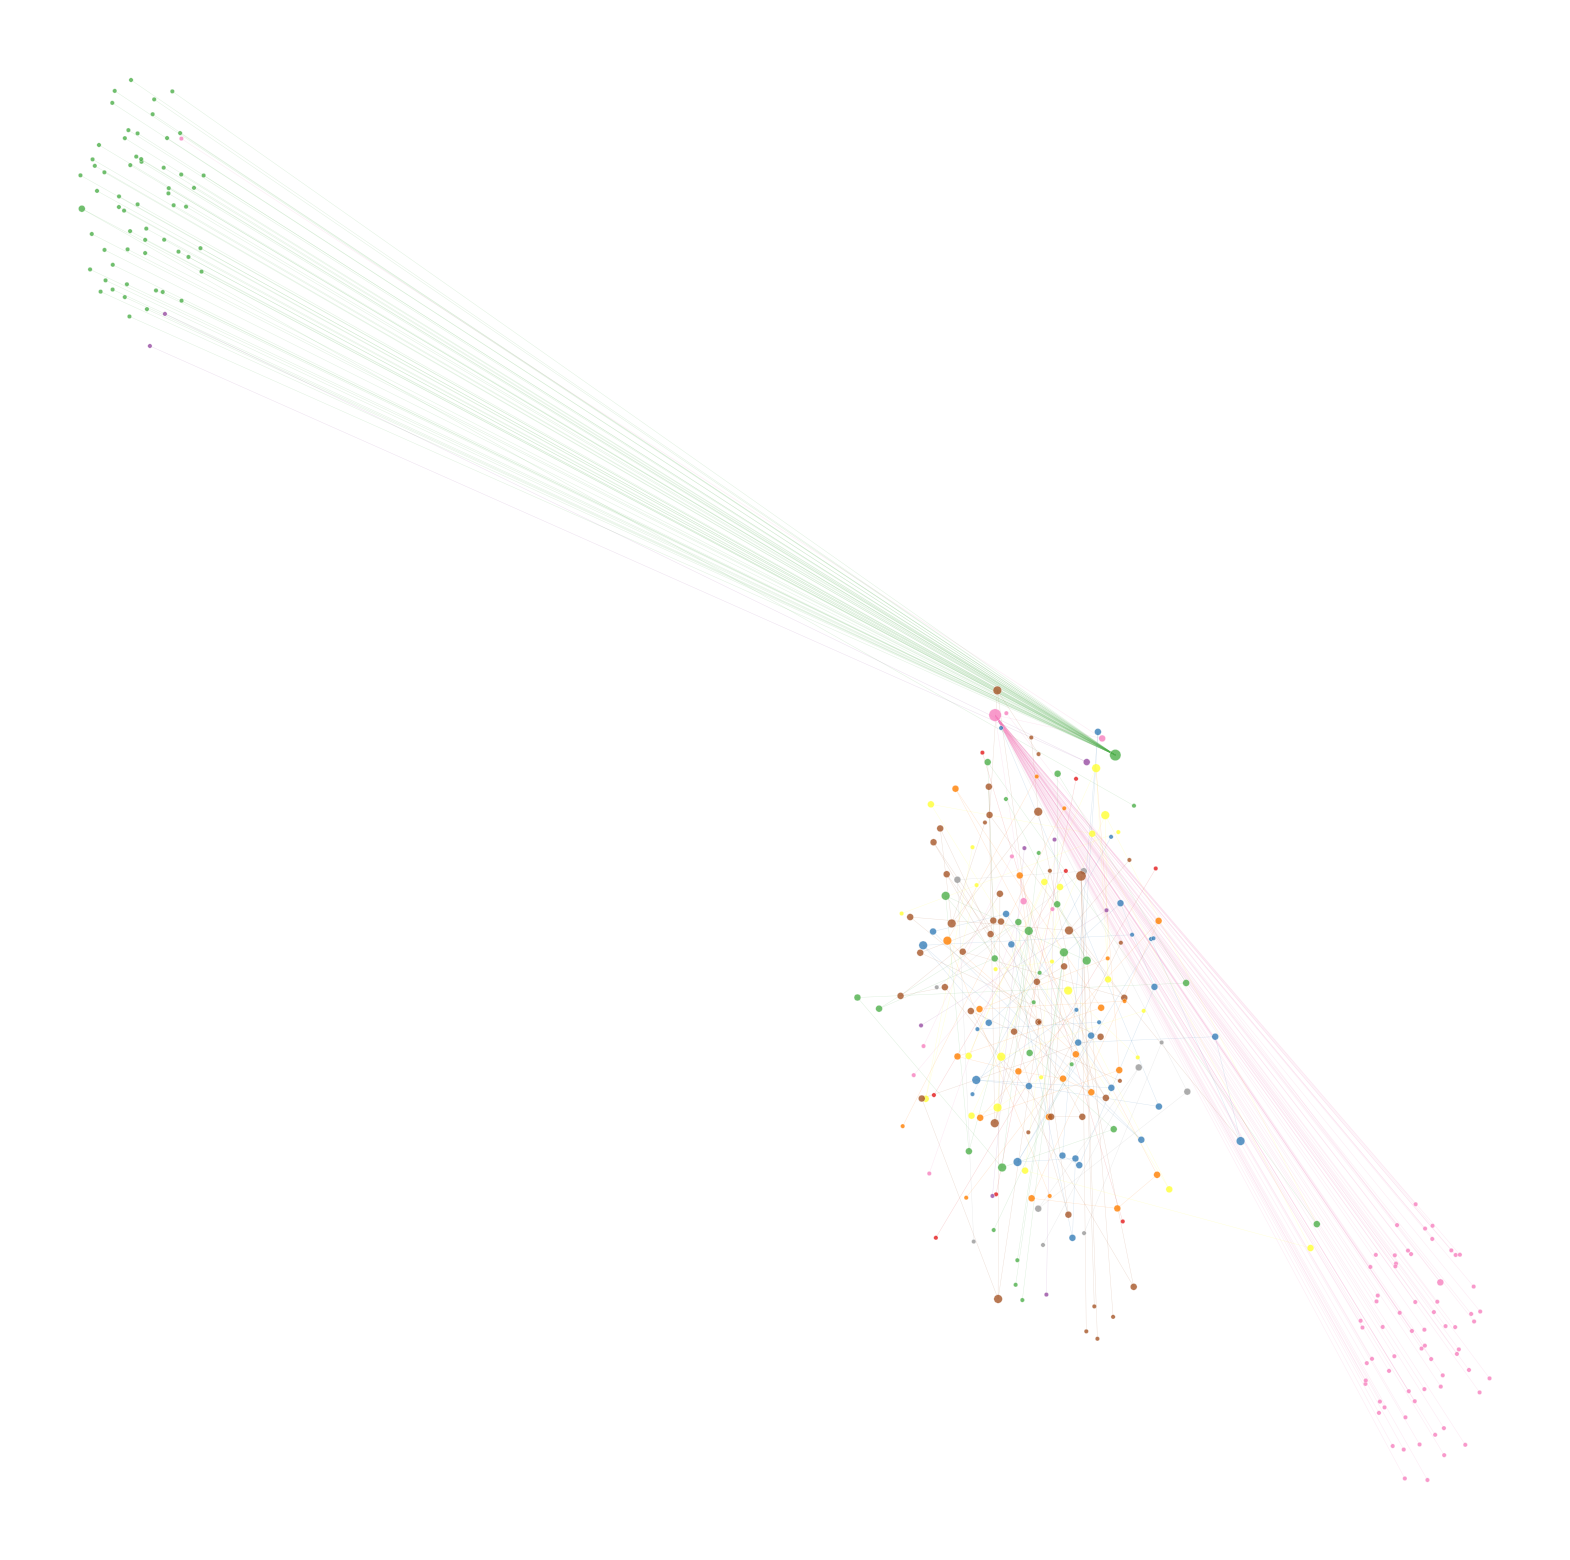

In [16]:
from graspologic.plot import networkplot

currtime = time.time()

# this is optional, may not need depending on the number of edges you have
sub_adj = subsample_edges(adj, 100_000)

# custom palette dictionary is missing many keys
# ax = networkplot(
#     sub_adj,
#     x="x",
#     y="y",
#     node_data=node_df,
#     node_size="rank_strength",
#     node_sizes=(10, 80),
#     figsize=(20, 20),
#     node_hue="community",
#     edge_linewidth=0.3,
#     palette=palette,
# )

ax = networkplot(
    sub_adj,
    x="x",
    y="y",
    node_data=node_df,
    node_size="rank_strength",
    node_sizes=(10, 80),
    figsize=(20, 20),
    node_hue="community",
    edge_linewidth=0.3,
)

ax.axis("off")

print(f"{time.time() - currtime:.3f} seconds elapsed.")